# Visualización de datos Copernicus Sentinel-1


En este notebook aprenderemos a visualizar datos de las coleeciones de Sentinel-1

### Importar colecciones

In [3]:
import openeo
import xarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec


### Credenciales

In [4]:
backend = "openeo.dataspace.copernicus.eu"
conn = openeo.connect(backend).authenticate_oidc()

Authenticated using refresh token.


### Llamar la colección de Sentinel- y ROI

In [5]:
polygon_coordinates = [
    [-85.53240006000608, 10.40371136444005],
    [-85.38339798481077, 10.40371136444005],
    [-85.38339798481077, 10.508711635260749],
    [-85.53240006000608, 10.508711635260749],
    [-85.53240006000608, 10.40371136444005]
]

s1 = conn.load_collection(
    "SENTINEL1_GRD",
    spatial_extent={
        "type": "Polygon",
        "coordinates": [polygon_coordinates],
        "crs": "EPSG:4326",
    },
    bands=["VV", "VH"],
    temporal_extent=["2023-01-01", "2023-06-08"],    #puede ajustar el rango de fechas
    properties={"sat:orbit_state": lambda od: od == "ASCENDING"},   # puede ajustar el paso de órbita
)

### Solicitud de datos preprocesados

Podemos solicitar datos SAR de Sentinel-1 convertidos a retrodispersión (backscattering). Esto no significa que las imágenes tengan un nivel de corrección RTC. 

Puede encontrar mayor información en [Documentación](https://docs.openeo.cloud/processes/#sar_backscatter)

### Colección valores lineales

In [19]:
s1_lin = s1.sar_backscatter(coefficient="sigma0-ellipsoid")

### Colección escala logarítmica

In [8]:
#### opción 2 con escala logaritmica
s1_log = s1.sar_backscatter(
    coefficient="sigma0-ellipsoid", elevation_model="COPERNICUS_30"
)
s1_log = s1_log.apply(lambda x: 10 * x.log(base=10))

### Descargar el netCDF

In [10]:
%time s1_log.download("sar_log.nc")

CPU times: user 286 ms, sys: 392 ms, total: 678 ms
Wall time: 2min 13s


### Visualicemos nuestro netCDF

In [17]:
s1_lin = xr.open_dataset("sar_lineales.nc")
s1_lin

<xarray.Dataset>
Dimensions:  (t: 14, x: 1638, y: 1170)
Coordinates:
  * t        (t) datetime64[ns] 2023-01-02 2023-01-14 ... 2023-05-26 2023-06-07
  * x        (x) float64 6.606e+05 6.606e+05 6.606e+05 ... 6.77e+05 6.77e+05
  * y        (y) float64 1.162e+06 1.162e+06 1.162e+06 ... 1.15e+06 1.15e+06
Data variables:
    crs      |S1 ...
    VV       (t, y, x) float64 ...
    VH       (t, y, x) float64 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [12]:
s1_log = xr.open_dataset("sar_lineales.nc")
s1_log

<xarray.Dataset>
Dimensions:  (t: 14, x: 1638, y: 1170)
Coordinates:
  * t        (t) datetime64[ns] 2023-01-02 2023-01-14 ... 2023-05-26 2023-06-07
  * x        (x) float64 6.606e+05 6.606e+05 6.606e+05 ... 6.77e+05 6.77e+05
  * y        (y) float64 1.162e+06 1.162e+06 1.162e+06 ... 1.15e+06 1.15e+06
Data variables:
    crs      |S1 ...
    VV       (t, y, x) float64 ...
    VH       (t, y, x) float64 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

### Compuestas Espaciotemporales SAR

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*aijgJZ5AoH5rwGO9"
     style="float: center; margin-right: 100px; width:300px" />




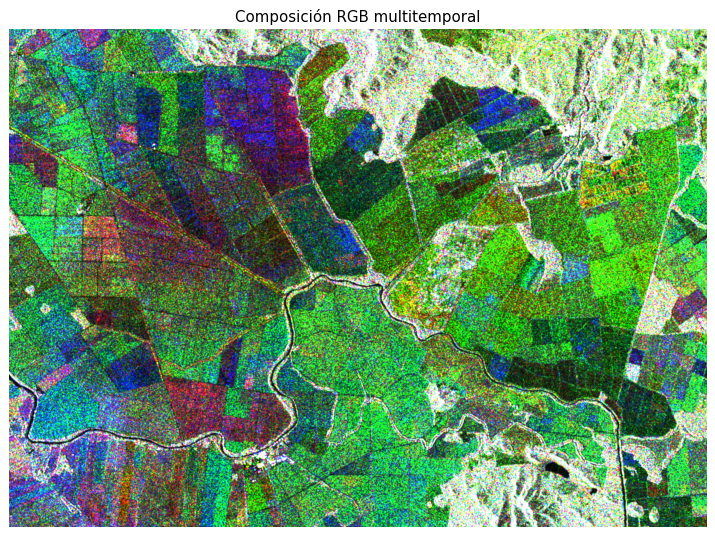

In [14]:

# Seleccionar los momentos de la serie temporal para la variable VH  
t1 = s1_log.sel(t=s1_log.t[2])['VH']  #R  
t2 = s1_log.sel(t=s1_log.t[6])['VH']  #G        # Ajuste las fechas
t5 = s1_log.sel(t=s1_log.t[-2])['VH'] #B

# Función para crear la imagen RGB
def create_rgb_image(r, g, b, min_val=0, max_val=1):
    r = np.clip(r, min_val, max_val)  
    g = np.clip(g, min_val, max_val)  
    b = np.clip(b, min_val, max_val)  
    
    r = (r - min_val) / (max_val - min_val)  
    g = (g - min_val) / (max_val - min_val) 
    b = (b - min_val) / (max_val - min_val)  
    
    rgb = np.stack([r, g, b], axis=-1)
    return rgb

# Crear la imagen RGB 
rgb_image = create_rgb_image(t1.values, t2.values, t5.values, min_val=0, max_val=0.05)

# Visualizar la imagen RGB
plt.figure(figsize=(10, 10), dpi=90)
plt.imshow(rgb_image)
plt.title('Composición RGB multitemporal')
plt.axis('off')
plt.show()

 Tal y como se hizo en el ejercicio en SNAP combine diferentes fechas y analice el comportamiento de los cultivos en el tiempo.

## Índice de Vegetación Radar (RVI)

Es un índice popular para evaluar la salud y el estado de la vegetación en el tiempo. Se sugiere como una alternativa o complemento al NDVI. Sin embargo su expresión original requiere de las polarizaciones HH y HV, mismas que no están disponibles para Sentinel-1. 

La adaptación del Índice de Vegetación Radar (RVI) para Sentienl-1 se define de la siguiente manera:

$$
\mathrm{RVI} = \frac{4 \sigma^0_{VH}}{\sigma^0_{VV} + \sigma^0_{VH}}
$$


### Implementación RVI 

In [20]:
#Use la colección con valores lineales

rvi = (4 * s1_lin.band("VH")) / (s1_lin.band("VV") + s1_lin.band("VH"))

### Nuevo netCDF

Este nuevo netCDF solo almacenará la variable del RVI y no las bandas VV y VH

In [21]:
rvi.download("RVI.nc")

In [22]:
# Abre el archivo NetCDF
rvi = xr.open_dataset('RVI.nc')

# Muestra la información del archivo
rvi

<xarray.Dataset>
Dimensions:  (t: 14, x: 1638, y: 1170)
Coordinates:
  * t        (t) datetime64[ns] 2023-01-02 2023-01-14 ... 2023-05-26 2023-06-07
  * x        (x) float64 6.606e+05 6.606e+05 6.606e+05 ... 6.77e+05 6.77e+05
  * y        (y) float64 1.162e+06 1.162e+06 1.162e+06 ... 1.15e+06 1.15e+06
Data variables:
    crs      |S1 ...
    var      (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [23]:
ds = xr.load_dataset("RVI.nc")
data = ds[["var"]].to_array(dim="bands")

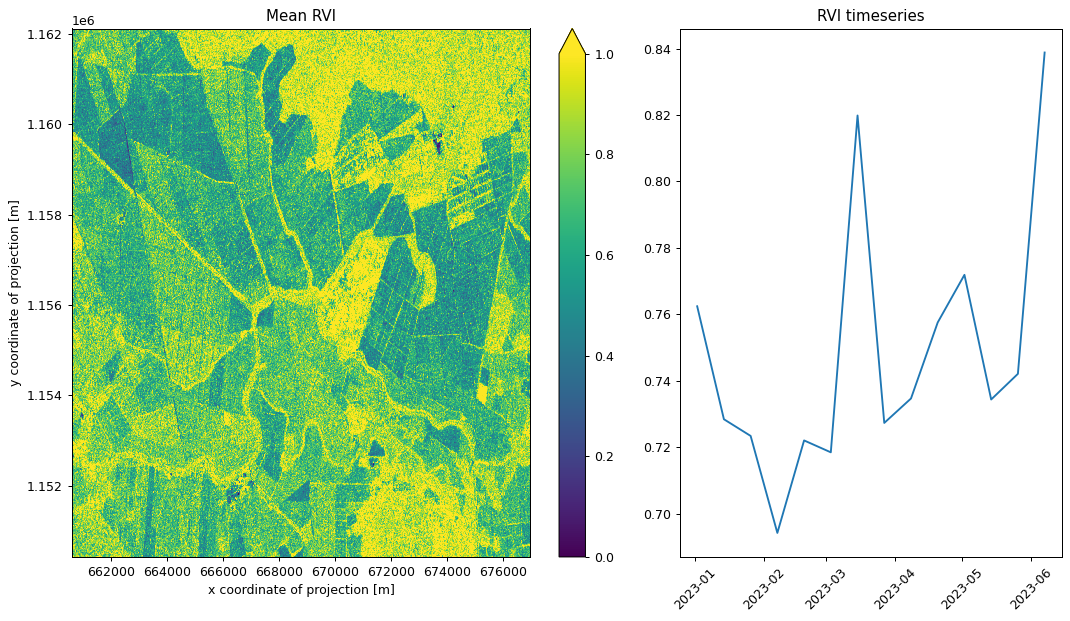

In [30]:
fig = plt.figure(figsize=(12, 7), dpi=90)
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2])

# Plot the image
ax0 = plt.subplot(gs[0])
data.mean(dim="t")[0].plot.imshow(vmin=0, vmax=1, ax=ax0)
ax0.set_title("Mean RVI")

# Plot the timeseries
ax1 = plt.subplot(gs[1])
ax1.plot(data.t.to_numpy(), data.mean(dim=("x", "y"))[0])
ax1.set_title("RVI timeseries")

plt.xticks(rotation=45)
plt.tight_layout()

La serie temporal deberiamos calcularla sobre un área específica, por ejemplo: una parcela/finca de un cultivo a monitorear. En el ejemplo se calcula la media de toda la imágen para cada observación t. 


### Acá finalizamos este ejercicio de visualización